# Ordinary Differential Equation Solver "Odie:" a C Code

## Authors: Gabriel M Steward

### January 2023

https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Template_Style_Guide.ipynb

Link to the Style Guide. Not internal in case something breaks. 

### </list_source_code> NRPy+ Source Code for this module:
[RK_Butcher_Table_Dictionary.py](/edit/RK_Butcher_Table_Dictionary.py)

[cmdline_helper.py](/edit/cmdline_helper.py)

[outputC.py](/edit/outputC.py)

## Introduction:
This Ordinary Differential Equation Solver, affectionately known as "Odie," takes a system of Ordinary Differential Equations (ODE) with a boundary condition and solves it Numerically, the result being a text file with the previously unknown function's values (it currently assumes only one part of the system is actually of any interest, which would be the case if the system was constructed from a higher-order ODE). The code is generic and can use any Runge Kutta-style method to solve the ODE. 15 different options ranging from first to eighth order are avialable within this notebook, and if the user has a butcher table that defines a unique method it can be inserted manually. In addition, the program supports an internal validation check which checks the order of the error.

Note that while this program does solve ODEs, it currently assumes that the ODE it is solving is already known and continually compares its results to the truth to check for errors. For an unknown result, the code would have to be altered slightly to not continually calculate errors. 

This is just the very beginnings of the code. It will be expanded to gain variable time-step functionality eventually. 

The user can specify a few values in the Customization section ([Step 2a](#S2a) below): the method used to solve the ODE, the step size, and how many steps to take. If the function needs to be changed the code itself has to be altered, but for most equations this won't be difficult. 

## </other>  Other:
A note: this notebook is not suitable as a tutorial yet, it is simply an explanation. When the project is finished, however, it should serve as a tutorial. 

### Note on Notation:
Any new notation will be brought up in the notebook when it becomes relevant. 

### Citations:

Matplotlib documentation. (Needs no citation?) 

<a id='1'></a>
[1] https://en.wikibooks.org/wiki/C_Programming/time.h (Using time.h)

<a id='2'></a>
[2] https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h (math.h compilation requirements)

<a id='3'></a>
[3] https://www.tutorialspoint.com/cprogramming/c_file_io.htm (Basic file operations)

<a id='4'></a>
[4] Numerical Mathematics and Computing 6E by Cheney and Kincaid (Primary Text)

<a id='5'></a>
[5] NRPy+ "Solving the Scalar Wave Equation" (Plotting code, surprisingly)

<a id='6'></a>
[6] https://www.dataquest.io/blog/read-file-python/ (Opening and reading CSV files)

<a id='7'></a>
[7] https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib (Changing size of plot)

<a id='8'></a>
[8] https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c (Need to determine what we are being handed by the butcher tables.)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

1. [Step 1:](#S1) Background: The Problem Statement

    2. [Step 1a:](#S1a) Validation Method

3. [Step 2:](#S2) The Code

    4. [Step 2a:](#S2a) Customization

    4. [Step 2b:](#S2b) Python-Code

    5. [Step 2c:](#S2c) C-Code

    6. [Step 2d:](#S2d) Results
    
7. [Step 3:](#S3) Additional Analysis

8. [Step 4:](#S4) Conclusion

9. [Step 5:](#S5) Output this notebook to $\LaTeX$-formatted PDF file

<a id='S1'></a>

# Step 1: Background: The Problem Statement \[Back to [top](#toc)\]
$$\label{S1}$$

#### In order to solve a problem, one must first know the problem exists.

This program seeks to take a system of Ordinary Differential Equations and solve it. To be clear, an Ordinary Differential Equation is an equation relating a function and its derivatives together, with the requirement that all derivatives be taken with respect to a single variable. If multiple variable derivatives are involved, it becoems a Partial Differential Equation. While the program only solves first-order ODEs, every higher-order ODE can be split up into a system of first-order ODEs, thus the program can solve any order ODE so long as the user splits it up into a system first, which is always possible for ODEs. 

Mathematically, our solver can solve equations of the form:

$$ \frac{dy(x)}{dx} = f(x,y(x)) ; \text{ given } y(a)=b$$

Where a system would take the form:

$$ \frac{dy_n(x)}{dx} = f(x,y_n(x)) ; \text{ given } y_n(a)=b_n$$

Where f is some function that does not contain any derivative or integral operators. A solution is to find what the function y(x) actually is. The given $y_n(a)=b_n$ are the boundary conditions for this problem. For this solver we start at the point a and increase it over time, treating it as an "initial condition." The program assumes $y_0(x)$ is the solution the user actually wishes to know and that any others are just there to help calculate that value. 

The program will restrict itself to Runge-Kutta type solution methods, which take an initial condition and evolve it forward in "time" with various relational methods, all of which are based in the Taylor Series Expansion. The specifics of these methods can be found elsewhere ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb)). The basic idea is that one value is used to calculate another value forward in "time," and this new value can be used to find the next one, and so on and so forth. Since we start with an initial condition, we can always use such methods. 

Of note: the problem can be solved with no information as to what y actually is. However, since this program is currently in its early stages, we are only using simple equations will very well known answers, so we make use of this and continuously compare the program's calculated result with the real one to see how our errors behave. 

<a id='S1a'></a>

## Step 1a: Validation Method \[Back to [top](#toc)\]
$$\label{S1a}$$

#### A program is worse than useless if it doesn't work and you don't know it.

An important part of simulation codes is validation--does the program do what we expect it to do when presented with known data? Since we have the solutions to the simple equations we are testing already present, we have an opportunity to see not only if our estimations are accurate, but also if the error terms behave as expected. Every method we use has an associated "error term" with it, $\mathcal{O}(h^m)$ where m is some integer that indicates the order of the error term. A first-order method would have m=2 since the method accurately represents terms up to m=1, and then the error is m=2. In words, a method of a certain order gets everything right up to that order, but not beyond it.

At the moment, we are concerned with the error with respect to the step size, which is how far in "time" we evolve the solution with every calculation. The question is, how exactly do we determine the order of a method from the data alone? If the order of error matches what we expect, we consider the method validated. 

To start, we can extract the error with the rather simple relation 

$$ \text{Truth} - \text{Calculation} = \text{Error} = \mathcal O(h^m) $$

Now, O-notation is somewhat ambiguous, for we do not know how large the term it represents is, and there can be terms of order higher than m that are supressed. If we assume that the m-order term dominates all the others, then we can write out

$$ E = Ah^m,$$

where E is error, A is some unknown constant, h is the step size, and m is the order. 

Let us say that we were to perform this error calculation twice: once for some unknown step value h, and once for precisely half, h/2. This would produce two different error values. 

$$ E_1 = Ah^m; E_2 = A \frac{h^m}{2^m}$$

We can solve both of these equaitons for A, which is the same in both.

$$ A = \frac{E_2}{h^m / 2^m} = \frac{E_1}{h^m} $$

From here we can just solve for m.

$$ \Rightarrow \frac{E_2}{E_1} = \frac{1}{2^m} $$
$$ \Rightarrow \frac{E_1}{E_2} = 2^m $$
$$ \Rightarrow m = log_2 \frac{E_1}{E_2} $$

Keep in mind that m is the order of the error term, the actual order of the method used would be m-1 in this case. So a first-order method would have m=2. Also be careful to keep the "1" and "2" subscripts on the errors in the right sequence, the $E_2$ comes from the halved step size. 

This method is very convenient for a few reasons. For one, it doesn't require any Taylor Series terms or any inputs aside from the first error terms of two separate calculations. In addition, the errors should be taken from the *first* step which means it isn't necessary to perform the calculations for the entire ODE twice just to get an order estimate. 

It does have a rather major failing though, and that comes with its primary assumption: that the errors are dominated by a single term. This need not be the case and often changes based on the step size. The other higher-order error terms do influence the result, and they can do it in unexpected ways, and as such the result "m" will rarely, if ever, actually be an integer. However, as we know it should be an integer, if we round all the problems from the other terms will usually go away, though not always. Fortuantely, as this validation is largely for the method itself and not the answer, it's always possible to just insert a different more well-behaved function for validation. We use one of these funcitons in the below code to make everything neat. Higher order methods break this more often than lower order methods, since higher order methods regularly hit roundoff error at low step sizes, larger step sizes are required to get actual error--and larger step sizes mean the relative differences between terms gets smaller. 0.1 reduces things by a factor of ten, which is regularly overruled by the leading cosntant, but 0.01's hundredth tends to win out. So it's very context dependent! 

There is a quirk that occurs if the Taylor Series Expansion of a solution is missing terms (or is finite). Say, for instance, the m=3 term was missing and we had an order 2 solver. Well, the order detector expects to find m=3, but instead it finds m=4 since there isn't any m=3 error term to find. This is not a problem, it is perfectly fine for a method to have an order *higher* than expected. Lower is when there would be a problem. Similar issues occur if the soluiton is exact or near exact, in which case the validation will claim the error order is infinite. 

Now that we have our tools, we are prepared to look at the actual program. 

<a id='S2'></a>

# Step 2: The Code \[Back to [top](#toc)\]
$$\label{S2}$$

#### Odie is our friend, but do we understand our friend?

Before looking at the code itself, lets first discuss how it operates. Before running the code, it is important to know that the user can manually set certain things in the code itself. Within the funciton `diffyQEval` lies the definition of the differential equation. For this notebook, we have u''=u+x as our declaration, written as `return y[1];` and `return y[0] + x;`. Any set of functions of y and x can be placed here, as the funciton is passed x and y variables when called. The y variable is passed as an array, carrying as many values as there are equations in the system. 

In the function `knownQEval` we have the known solution. In this case it is $e^x-1$ represented by `return exp(x) + exp(-x) - x;`. This is not strictly needed, as the program can find the solution on its own, but as we are very concerned with errors we want a truth to continually check against. 

The boundary condition needs to be declared as well. The variables for them are in the main function, with `bound` being the location of the boundary, and `bValue` being the values *at* that point for the various derivatives. It's best to think of x as being `bound` and the y values as being `bValue`. 

There are a set of mutable parameters that determine how the simulation is run, both of which can be set within this notebook in the Customization section ([Step 2a](#S2a) below). `step` is the step size, which we have set to 0.01 by default for these tests. Smaller numbers mean better accuracy here. `SIZE` is how large the area we're solving for is. We start at `bound` but `SIZE` determines where we end. We have it set to 1000 in this notebook. 

In addition, the method can also be chosen by setting `key` to one of the many options for solving methods, which are listed in the Customization section. "RK4" is the standard choice, but we have it set to "Euler" by default since the least-accurate method is the easiest to see differences between exact and calculated answers. If a user wants accurate data, it is highly recommended to choose another method. 

Lastly, there is a boolean variable `validate` which should be set to true if validation is desired, and false if not. We naturally have it set to true here. 

Once all these parameters are set, the notebook can be run, and the first thing it does is construct the chosen method from NRPy+'s library, crafting a "butcher table" that the C-code can put into use. After that, it opens a new folder to put all the C-related files into, and uses NRPy+'s `OutputC` functions to create the actual function that does the evaluating. 

Once all the setup with Python is done, the C-code activates, sets up a timer to let the user know how many seconds the operation took, and opens a file to write all the output to. After that, it executes the chosen method via the butcher table, the specifics of which we shall not go into since they are described elsewhere ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb)). What should be noted is that on the first step, if `validation` is set to true, the code will attempt to evaluate the order of the error. It will always spit out something (even if that something is N/A or infinity), but any of these non-number results genreally mean the result is "too accurate" and the method is looking at computer roundoff error rather than actual error inherent in the method itself. If validation is still desired for a high accuracy method, increasing the step size should do the trick. 

With the calculation complete, the program closes the file it was writing to, `oData.txt`, reports the time taken in seconds, and ends. It makes sure to add commas so the output can also be read as a .csv, which is useful for analysis with Python, which we will do at the end of this notebook. 

<a id='S2a'></a>

## Step 2a: Customization \[Back to [top](#toc)\]
$$\label{S2a}$$

#### Wealth, fame, power, accuracy... all of it is on offer for the right combination of settings.

Here is where users can adjust information in the notebook to adjust how the program runs. This will change the Results section, but not Expanded Results, which uses data from previous runs that will not change. 

In [1]:
#This is the method variable, used to choose how the program calculates the result. 
key = "RK4"
#Possible options: "Euler" (Order 1), "RK2 Heun" (Order 2), "RK2 MP" (2), 
#"RK2 Ralston" (2), "RK3" (3), "RK3 Heun" (3), "RK3 Ralston" (3), "SSPRK3" (3),
#"RK4" (4), "DP5" (5), "DP5alt" (5), "CK5" (5), "DP6" (6), "L6" (6), "DP8" (8) 

#This is the step size. 
step = "0.01"
#Can be any number, 0.01 by default. Note that this is a string--we are passing it to
#the C code generator as a string. Be very sure not to declare it as something that isn't
#a number. 

#This is the number of steps.
size = "100"
#Can be any integer, 1000 by default. Be sure to make it actually be an integer. 

#more coming eventually: functions and boundary values.
#though those two might be a while. 

<a id='S2b'></a>

## Step 2b: Python-Code \[Back to [top](#toc)\]
$$\label{S2b}$$

#### Can't do anything if there's nothing to do it with!

Naturally, one does not just automatically push a Python-codified Butcher table into a C-code. We have to actually grab it and format the Butcher Table in such a way that it can be understood. Which means formatting a string into a C-command based on the provided Butcher Tables from NRPy. 

In [2]:
import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import numpy as np              # NumPy: A numerical methods module for Python
from RK_Butcher_Table_Dictionary import Butcher_dict #the Butcher Tables themselves. 

#The end result of all this should be a string with our chosen method. 
#If you want to set the method, see above. 

butcherTable = ""

#Now in order to determine what size to make our loop, we need the size of the table itself.
print(len(Butcher_dict[key][0]))
rows = len(Butcher_dict[key][0])
i = 0

#Set up th edeclaration of the double 2D array in C. 
butcherTable = butcherTable + "double butcher[" + str(len(Butcher_dict[key][0])) + "][" + str(len(Butcher_dict[key][0])) +"] = {"

while (i < rows):
    print(len(Butcher_dict[key][0][i]))
    #The above print function helps us see that the program really is doing the entire matrix.
    columns = len(Butcher_dict[key][0][i])
    butcherTable = butcherTable + "{"
    #Even though the matrix is square, we cannot set rows=columns since 
    #The butcher tables have a lot of empty slots we will be filling with 0s. 
    j = 0
    if Butcher_dict[key][0][i][j] == '':
        butcherTable = butcherTable + str(float(Butcher_dict[key][1]))+ ","
        j = j+1
        # This is a check for the empty spot in the bottom left of the table
        # the C-code uses this to store the method order, so we put it there. 
        # The main bennefit is that this keeps the matrix square.
    while (j < rows): #not < columns, since we still need to fill in 0s for 
        #the C code. 
        if (j < columns):
            butcherTable = butcherTable + str(float(Butcher_dict[key][0][i][j]))
            # Print the number requested. 
            # Note the conversion to floating point. The C-code has no clue what to
            # do with fractions, so they must be changed. 
            if (j<rows-1):
                butcherTable = butcherTable + ","
                #if not at end of row, add comma. WE don't want to overdo it. 
        elif (j < rows-1):
            butcherTable = butcherTable + "0"+ ","
            # if we are at the point where there are no numbers, fill with 0. 
        else:
            butcherTable = butcherTable + "0"
            # if we are at the point where there are no numbers, fill with 0. 
            # end of row does not have the comma addition. 
        j = j+1
    if(i < rows-1):
        butcherTable = butcherTable + "},"
    else:
        butcherTable = butcherTable + "}"
    # After every row, we need a brace, but the added comma is not needed on the last one.
    i = i+1
butcherTable = butcherTable + "};"
print(butcherTable)



5
1
2
3
4
5
double butcher[5][5] = {{0.0,0,0,0,0},{0.5,0.5,0,0,0},{0.5,0.0,0.5,0,0},{1.0,0.0,0.0,1.0,0},{4.0,0.16666666666666666,0.3333333333333333,0.3333333333333333,0.16666666666666666}};


With that, now we can start setting up the file within which we will run the C code. Now we can actually use some functionality form NRPy+ proper! NRPy+ is designed to use Python to generate C codes. To do this, we start by creating the directory. 

In [3]:
import outputC as outC       #NRPy+: Core C code output module.
import cmdline_helper as cmd #NRPy+: Multi-platform Python command-line interface
import os                    #Python: Miscellaneous operating system interfaces
import shutil                #Python: High level file operations

# https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb

#Create a C code output directory
#First, name it.
Ccodesrootdir = os.path.join("ODESolver_Ccodes/")
#Remove any previously existing files there.
shutil.rmtree(Ccodesrootdir,ignore_errors=True)
#Create the fresh directory. 
cmd.mkdir(Ccodesrootdir)

Now that we have the directory, the primary way in which NRPy+ generated C-codes is by creating a function that adds the C-code to an internal C-function dictionary. Most of it is occupied by C-code, so... 

<a id='S2c'></a>

## Step 2c: C-Code \[Back to [top](#toc)\]
$$\label{S2c}$$

#### Behold, the solver. 

Below is the C-Code. Numerous output lines are commented out and can be un-commented at will if a user wishes to examine in more detail what's happening during runtime. (Though in this notebook that is likely not necessary as the terminal output is just placed in a text file.) Code is heavily commented, some of it is likely redundant with the section above, but looking at things two different ways rarely hurts. 

The C-code generated here can also be found in pure C form, though it only has one of each of the first five orders of solution methods as possibilities. 

In [4]:
#now define our c function itself.
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h", "time.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = r"""
    double diffyQEval (double x, double y[], int i)
    {
        switch(i){
            case 0: {
                return y[1]; 
                //we use 0 to represent the answer we eventually want to get
                //in this case, the solution to y'' = y+x, stated here as y'=z
                break;
            }
            case 1: {
                return y[0] + x;
                //1 represents the first derivative. y''=y+x, but when we split it up we got y'=z. This equation returns the value
                //for the z derivative, z'=y+x
                break;
            }
            // case...
            //add more cases for higher order systems. 
            default: {
                //Any number could be a result, theoretically, so there isn't an easy error value to put here.
            }
        }
        //This is the differential equation system itself. 
        //By default we have a very simple y'' = y+x situation here, split up into
        // y[0]' = y[1]
        // y[1]' = y[0]+x
        //Naturally other equaitons can be put in, but be sure to change the numberOfEquations value!
        //feel free to change the return values to other functions. 
        //Note: not guaranteed to work for functions that are not well-behaved. 
        //We have this set up so y[0] would be the final "answer" for a split-up higher-order ODE. 
    }

    //This is the function to evaluate the known solution. Must be set manually.
    double knownQEval (double x)
    {
        return exp(x) + exp(-x) - x;
        //the known solution to the differential equaiton, specifically what we call y[0]
        //used to measure relative errors. 
        //"exp(x) + exp(-x) - x" is "default." as it is the answer to the differential equation we chose. 
        //Do note that this would change with different boundary conditions. 
    }
    """
    #prefunctions are functions declared outside main. In this case, we have the 
    #differential equation and the known exact solution. 
    
    desc = "Fill out later"
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    body = butcherTable + r"""
    printf("Beginning ODE Solver \"Odie\" V4...\n");
    
    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the function itself chosen. 
    //The diffyQ itself can be found declared in diffyQEval().

    //How to get array size: https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c
    size_t methodSize = sizeof(butcher)/sizeof(butcher[0][0]);
    int dimension = sqrt((int)methodSize);
    printf("Method Order: %i. \nOrder of Error should be near Method Order + 1.\n",(int)butcher[dimension-1][0]);
    printf("If not, try a larger step size, roundoff error may be interfering.\n");

    double step = """ + step + r"""; //the "step" value.
    double bound = 0.0; //where the boundary/initial condition is.
    int numberOfEquations = 2; //How many equations are in our system?
    //Be very careful setting these boundary conditions, they need to match the number of equations. 
    double bValue[numberOfEquations]; 
    bValue[0] = 2.0;
    bValue[1] = -1.0;
    //the value at y(bound). By default we say y(0) = 0.
    const int SIZE = """ + size + r"""; //How many steps we are going to take?
    bool validate = true; //set to true if you wish to run a validation test.
    //Attempts to find the order of the method used. 

    double y1[numberOfEquations];
    double y2[numberOfEquations];
    double yTruth1;
    double yTruth2;
    double yError;
    //These variables temporarily store the values calculated before they are 
    //printed to the output file and forgotten. 
    //y is what we solve for, yTruth is the "known results."
    //yError is the error of y when compared to yTruth
    //Should be able to handle any size, unlike arrays, which just hog memory. 
    //Errors and Truth are not arrays as they are only concerned with the final value. 

    for (int n = 0; n < numberOfEquations; n++) {
        y1[n] = bValue[n];
        //Assign the initial values to the boundary conditions. 
    } 
    yTruth1 = knownQEval(bound);
    yError = 0; //has to be zero as they must match at this point. 
    //If not, the boundary conditions were not stated properly. 

    double saveErr1=0, saveErr2=0; //variables for validation if requested. 
    
    //SECTION II: The Loop

    //prior to beginning the loop, start the timer. 
    double startN = time(NULL);
    //printf("Time: %.90f seconds\n", startN);
    //set start time to current time.  Uncomment to print.

    //also open the file we'll be writing data to. 
    FILE *fp;
    fp = fopen("oData.txt","w");

    //This loop fills out all the data.
    //It takes a provided butcher table and executes the method stored within. Any table should work. 
    printf("INITIAL: Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound,yTruth1, y1[0], yError);
    fprintf(fp,"Position:,\t%f,\tTruth:,\t%10.9e,\tCalculated:,\t%10.9e,\tError:,\t%10.9e,\t\n",bound,yTruth1, y1[0], yError);
    //Comma delimiters are printed to the file so it can be converted to .csv with ease. 
    
    for (int i = 0; i < SIZE; i++){ 
        //printf("%i",m);
        double K[dimension][numberOfEquations];
        //Since we'll be calling this while it's empty, even though there should be no errors due
        //to the way it's set up, let's go ahead and fill it with zeroes.
        for (int j = 0; j<dimension; j++) {
            for (int n = 0; n<numberOfEquations; n++) {
                K[j][n]=0.0;
            }
        }
        //each diffyQ has its own set of K-values, one for each equation. 

        double yInsert[numberOfEquations];
        //We also need an array for the inserted y-values for each equation. 
        //Most applications actually have the different yInsert values be independent, so 
        //if we knew the form of the equation we could simplify the code.
        //However, we need to make sure to always fill everything in case we have a system
        //of the form y'=f(u,y) u'=g(u,y)

        for (int j = 1; j < dimension; j++) {
            //Due to the way the Butcher Table is formatted, start our index at 1 and stop at the end. 
            double xInsert = bound+i*step + butcher[j-1][0]*step;
            //x does not change much for different tables, just adjust the "step correction" term.
            //Is the same for every equation too.

            for (int n = 0; n < numberOfEquations; n++) {
                yInsert[n] = y1[n];
            } 

            for (int n = 1; n < dimension; n++) {
                //Once again, start at index of 1 rather than 0.
                for (int q = 0; q < numberOfEquations; q++) {
                    yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                }
                //Each individual y portion is dependent on one of the K values.
                //K values are initially set to zero even though technically whenever 
                //we would use an undeclared K-value the butcher table would have zero.
                //You know, just in case something goes wrong. 
            }

            for (int n = 0; n < numberOfEquations; n++) {
                K[j][n] = step*diffyQEval(xInsert,yInsert,n);
                //Actually calculate the K-values.
            } 

        }
        //Now that we have all the K-values set, we need to find the actual result in one final loop.
        //The sum for the first set... 
        for (int n = 0; n< numberOfEquations; n++) {
            K[0][n] = y1[n];
            for (int j = 1; j < dimension; j++) {
                K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n];
            }
            y2[n] = K[0][n];
        }
        
        yTruth2 = knownQEval(bound+step*(i+1));
        yError = (yTruth2 - y2[0]);

        //After each step is calculated, print results. 
        //printf("Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+(i+1)*step,yTruth2, y2, yError);
        //uncomment if you want live updates. 
        //if (m==0) {
            fprintf(fp,"Position:,\t%f,\tTruth:,\t%10.9e,\tCalculated:,\t%10.9e,\tError:,\t%10.9e,\t\n",bound+(i+1)*step,yTruth2, y2[0], yError);
        //}
                
        //validation: grab the first nonzero error, calculate its order.
        //Currently broken. 
        if(validate==true && i == 0.0) { //currently set to ignore this. REMEMBER TO TURN BACK ON LATER!
            //Only activate on first step. 
            saveErr1 = yError;

            //The following is an algorithm for determining the rate of error 
            //convergence. A bit rudimentary, could be condensed, but is also only
            //called once so not relaly a concern and it is easier to read this way. 
            double step2 = step*0.5;
            //It is easier to just use another variable than multiply the step by 0.5 every time. 
                for (int j = 0; j<dimension; j++) {
                    for (int n = 0; n<numberOfEquations; n++) {
                        K[j][n]=0.0;
                    }
                }
                for (int j = 1; j < dimension; j++) {
                    double xInsert = bound+i*step2 + butcher[j-1][0]*step2;
                    for (int n = 0; n < numberOfEquations; n++) {
                        yInsert[n] = y1[n];
                    } 
                    for (int n = 1; n < dimension; n++) {
                        for (int q = 0; q < numberOfEquations; q++) {
                            yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                        }
                    }
                    for (int n = 0; n < numberOfEquations; n++) {
                        K[j][n] = step2*diffyQEval(xInsert,yInsert,n);
                    } 
                }
                for (int n = 0; n< numberOfEquations; n++) {
                    K[0][n] = y1[n];
                    for (int j = 1; j < dimension; j++) {
                        K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n];
                    }
                }
            double truthValidate = knownQEval(bound+step2);
            saveErr2 = (truthValidate - K[0][0]);
            //Basically we just calculated the initial error for half step size. 
            //Now we can compare using the equation for order estimation:
            double order =  log2(saveErr1/saveErr2);
            printf("Order of Error: %f\n", order);
        }
        
        for (int n = 0; n < numberOfEquations; n++) {
            y1[n]=y2[n];
        } 
        //make sure to assign all variables to the next step. 
        yTruth1=yTruth2;
         
    }

    //SECTION III: Analysis
    //Post-processing goes here.

    // basic reference: https://www.tutorialspoint.com/cprogramming/c_file_io.htm
    // used to be a file converter here, now there isn't, we just close the file. 
    fclose(fp);

    //TIMER
    double endN = time(NULL);
    //loop is complete, how long did it take?
    printf("Time Elapsed: %f seconds\n", endN-startN);
    //Only calculates to the closest second, for some reason.

    printf("ODE Solver \"Odie\" V4 Shutting Down...\n");
    return 0;

// - GM, master of dogs.
    """
    
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolver", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolver", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
main.c: In function ‘diffyQEval’:
main.c:36:5: warning: control reaches end of non-void function [-Wreturn-type]
   36 |     }
      |     ^
(BENCH): Finished executing in 0.20 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolver `...
(BENCH): Finished executing in 0.21 seconds.


References in the code above are 

[1](#1) https://en.wikibooks.org/wiki/C_Programming/time.h

[2](#2) https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

[3](#3) https://www.tutorialspoint.com/cprogramming/c_file_io.htm

[4](#4) Numerical Mathematics and Computing 6E by Cheney and Kincaid

[8](#8) https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c 

So, what do we get when we run this code? Well...

<a id='S2d'></a>

## Step 2d: Results \[Back to [top](#toc)\]
$$\label{S2d}$$

#### If it isn't the consequences of my own actions

First, let's see what the terminal printed. 

In [5]:
with open("terminalOutput.txt") as f:
    print(f.read())

Beginning ODE Solver "Odie" V4...
Method Order: 4. 
Order of Error should be near Method Order + 1.
If not, try a larger step size, roundoff error may be interfering.
INITIAL: Position:	0.000000	Truth:	2.000000000e+00	Calculated:	2.000000000e+00	Error:	0.000000000e+00	
Order of Error: -nan
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V4 Shutting Down...



Was the order of error roughly equal to the method error plus 1? It should be, though if it's much larger than that it's not a big concern, as it is perfectly fine for a method to be more accurate than predicted.

If the result spat out a bunch of inf or nan values for Order of Error, it likely means the method was "too accurate" to get good error readings, in which case why not try a smaller step size if you really want to validate that the method itself is working properly? 

The time.h program only does whole seconds for now, so all we can say is that it took less than 1 second. 

The actual data produced by the program is below. Note: if you chose a large SIZE it will be a very long result. 

In [6]:
with open("oData.txt") as f:
    print(f.read())

Position:,	0.000000,	Truth:,	2.000000000e+00,	Calculated:,	2.000000000e+00,	Error:,	0.000000000e+00,	
Position:,	0.010000,	Truth:,	1.990100001e+00,	Calculated:,	1.990100001e+00,	Error:,	2.664535259e-15,	
Position:,	0.020000,	Truth:,	1.980400013e+00,	Calculated:,	1.980400013e+00,	Error:,	3.907985047e-14,	
Position:,	0.030000,	Truth:,	1.970900068e+00,	Calculated:,	1.970900068e+00,	Error:,	1.083577672e-13,	
Position:,	0.040000,	Truth:,	1.961600213e+00,	Calculated:,	1.961600213e+00,	Error:,	2.113864639e-13,	
Position:,	0.050000,	Truth:,	1.952500521e+00,	Calculated:,	1.952500521e+00,	Error:,	3.474998067e-13,	
Position:,	0.060000,	Truth:,	1.943601080e+00,	Calculated:,	1.943601080e+00,	Error:,	5.169198403e-13,	
Position:,	0.070000,	Truth:,	1.934902001e+00,	Calculated:,	1.934902001e+00,	Error:,	7.200906538e-13,	
Position:,	0.080000,	Truth:,	1.926403414e+00,	Calculated:,	1.926403414e+00,	Error:,	9.565681580e-13,	
Position:,	0.090000,	Truth:,	1.918105469e+00,	Calculated:,	1.918105469e+00,	Error:

And those are the results in raw form. Below are some graphs generated from the data produced. 

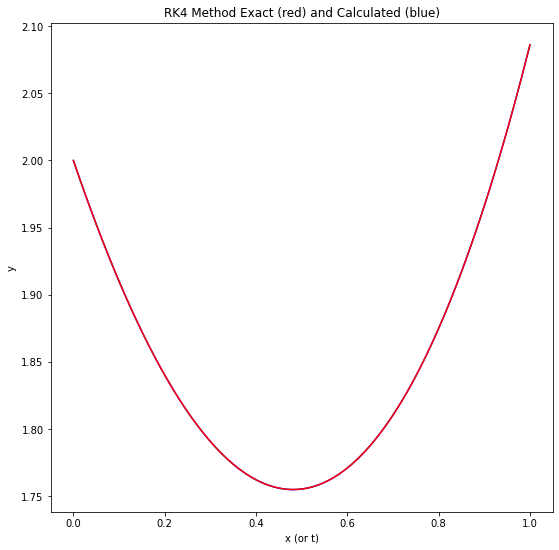

In [7]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title(key + ' Method Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='b')
ax.plot(positionList, calculatedList, color='r')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

For most methods you likely won't see a difference between exact and calculated, so it's often better to examine the error directly. 

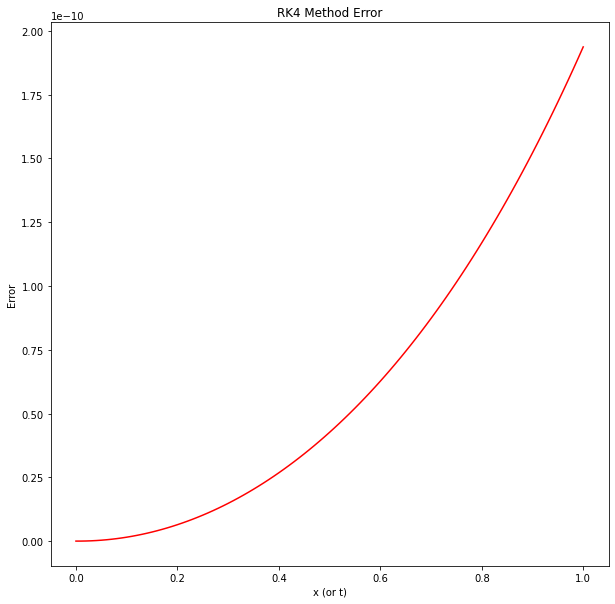

In [8]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Method Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

We often care more about error closer to the start point, so a logarithmic plot is often more illuminating as to how the error actually goes. 

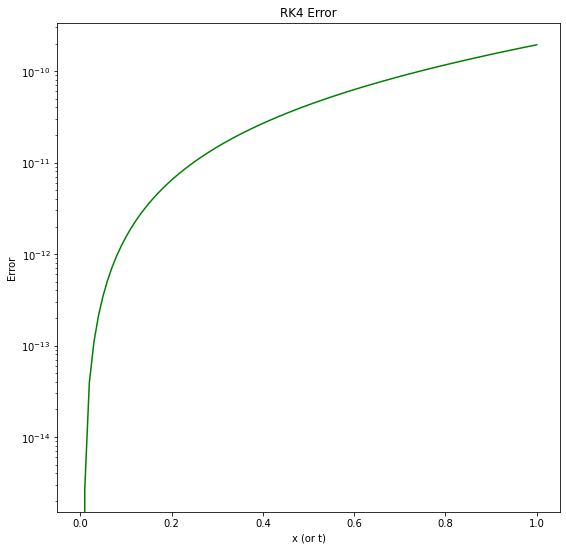

In [9]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(abs(float(row[7])))
        #remember to absolute value for log plots, otherwise negative values
        #shoot off the deep end.

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Error')
ax.plot(positionList, errorList, color='g')
ax.set_yscale("log") #found in matplotlib's documentation.
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)

And an even better measure of the error would be the relative error, where we divide the error by the exact value. 

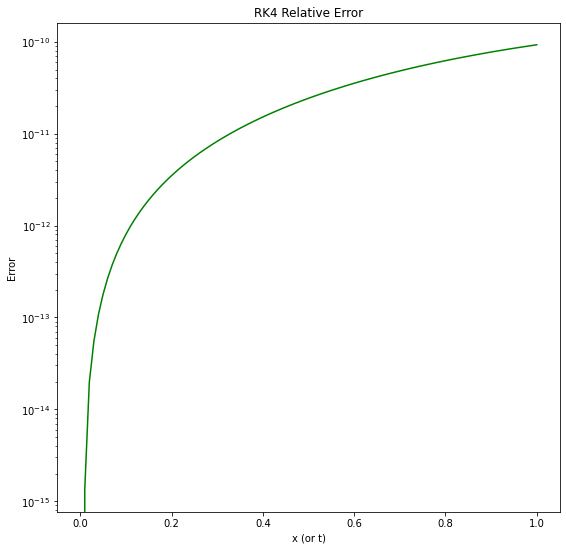

In [10]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(abs(float(row[7]) / (float(row[3])+0.00000000000000001)))
        #that tiny number is added to prevent division by zero
        #it always occurs on the first step, and can occur later when exact answers arise.

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Relative Error')
ax.plot(positionList, errorList, color='g')
ax.set_yscale("log") #found in matplotlib's documentation.
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)

For reasons unknown matplotlib has issues plotting the logarithmic scale of an arbitrary set of data, working on it. Likely because it stays within one order of magnitude. 

Regardless, here's the relative error without the log scale.

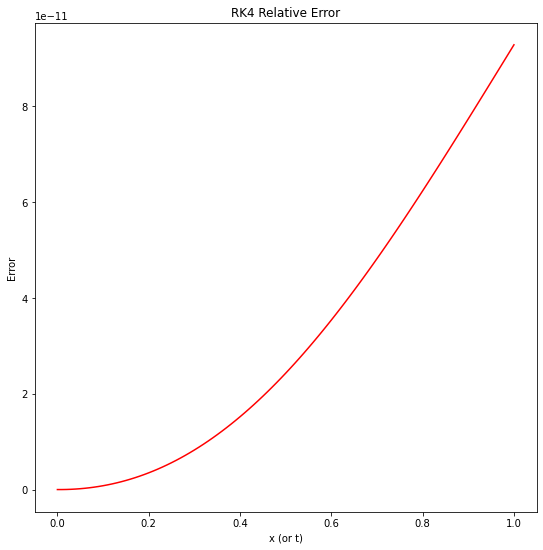

In [11]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]) / (float(row[3])+0.00000000000000001))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(key + ' Relative Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)

<a id='S3'></a>

# Step 3: Additional Analysis \[Back to [top](#toc)\]
$$\label{S3}$$


#### A truly absurd number of graphs awaits

Now, understandably, we might want to analyze the larger-scale behavior of the program, and depending on what the user input at the start of this notebook is that could change (or even break!). So, for discussion, we use previous runs of the code on the ODE u'' = u+x.

To start, Euler's method produces:

```
Beginning ODE Solver "Odie" V4...
Method Order: 1. 
Order of Error should be near Method Order + 1.
If not, try a larger step size, roundoff error may be interfering.
INITIAL: Position:	0.000000	Truth:	2.000000000e+00	Calculated:	2.000000000e+00	Error:	0.000000000e+00	
Order of Error: 2.000009
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V4 Shutting Down...
```

Note that the order of error is about 2, as expected. Note that it reports "0 seconds". The time.h program only does whole seconds for now, so all we can say is that it took less than 1 second. 

And the actual data itself is:

```
Position:,	0.000000,	Truth:,	2.000000000e+00,	Calculated:,	2.000000000e+00,	Error:,	0.000000000e+00,	
Position:,	0.010000,	Truth:,	1.990100001e+00,	Calculated:,	1.990000000e+00,	Error:,	1.000008333e-04,	
Position:,	0.020000,	Truth:,	1.980400013e+00,	Calculated:,	1.980200000e+00,	Error:,	2.000133335e-04,	
Position:,	0.030000,	Truth:,	1.970900068e+00,	Calculated:,	1.970600000e+00,	Error:,	3.000675020e-04,	
Position:,	0.040000,	Truth:,	1.961600213e+00,	Calculated:,	1.961200020e+00,	Error:,	4.001933447e-04,	
Position:,	0.050000,	Truth:,	1.952500521e+00,	Calculated:,	1.952000100e+00,	Error:,	5.004208767e-04,	
Position:,	0.060000,	Truth:,	1.943601080e+00,	Calculated:,	1.943000300e+00,	Error:,	6.007801276e-04,	
Position:,	0.070000,	Truth:,	1.934902001e+00,	Calculated:,	1.934200700e+00,	Error:,	7.013011462e-04,	
Position:,	0.080000,	Truth:,	1.926403414e+00,	Calculated:,	1.925601400e+00,	Error:,	8.020140056e-04,	
Position:,	0.090000,	Truth:,	1.918105469e+00,	Calculated:,	1.917202520e+00,	Error:,	9.029488084e-04,	
Position:,	0.100000,	Truth:,	1.910008336e+00,	Calculated:,	1.909004200e+00,	Error:,	1.004135692e-03	

```

We can easily construct similar data for any other Butcher Table. Here is RK4. 

```
Beginning ODE Solver "Odie" V4...
Method Order: 4. 
Order of Error should be near Method Order + 1.
If not, try a larger step size, roundoff error may be interfering.
INITIAL: Position:	0.000000	Truth:	2.000000000e+00	Calculated:	2.000000000e+00	Error:	0.000000000e+00	
Order of Error: 6.000189
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V4 Shutting Down...
```
Note that the order of error given is 6, not 5. This is usually because we have solution that doesn't have a 5th order term in the Taylor Expansion. 

```
Position:,	0.000000,	Truth:,	2.000000000e+00,	Calculated:,	2.000000000e+00,	Error:,	0.000000000e+00,	
Position:,	0.100000,	Truth:,	1.910008336e+00,	Calculated:,	1.910008333e+00,	Error:,	2.778273611e-09,	
Position:,	0.200000,	Truth:,	1.840133511e+00,	Calculated:,	1.840133472e+00,	Error:,	3.898120737e-08,	
Position:,	0.300000,	Truth:,	1.790677028e+00,	Calculated:,	1.790676919e+00,	Error:,	1.091940054e-07,	
Position:,	0.400000,	Truth:,	1.762144744e+00,	Calculated:,	1.762144529e+00,	Error:,	2.146787335e-07,	
Position:,	0.500000,	Truth:,	1.755251930e+00,	Calculated:,	1.755251573e+00,	Error:,	3.573925431e-07,	
Position:,	0.600000,	Truth:,	1.770930436e+00,	Calculated:,	1.770929896e+00,	Error:,	5.400162870e-07,	
Position:,	0.700000,	Truth:,	1.810338011e+00,	Calculated:,	1.810337245e+00,	Error:,	7.659938797e-07,	
Position:,	0.800000,	Truth:,	1.874869893e+00,	Calculated:,	1.874868853e+00,	Error:,	1.039582946e-06,	
Position:,	0.900000,	Truth:,	1.966172771e+00,	Calculated:,	1.966171405e+00,	Error:,	1.365917402e-06,	
Position:,	1.000000,	Truth:,	2.086161270e+00,	Calculated:,	2.086159519e+00,	Error:,	1.751082823e-06,		
```

Note how the error gets much, much smaller the higher the order of the calculation method. RK4 was so good that the step size 0.01 breaks the validation checker since it's so accurate! 

Below this, we make a large number of graphs, including those made from multiple runs of the program.

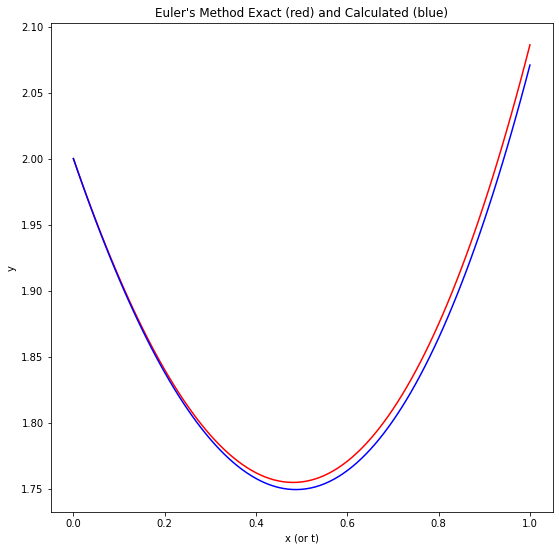

In [12]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/EulerData1.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Euler\'s Method Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='r')
ax.plot(positionList, calculatedList, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

[5](#5) NRPy+ "Solving the Scalar Wave Equation"

[6](#6) https://www.dataquest.io/blog/read-file-python/

[7](#7) https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib

We note that the two lines are rather close, even for the least accurate method we have. The calculated value clearly gets less accurate over time. Higher order methods have no visible difference at this scale, as we can see with RK4 below. 

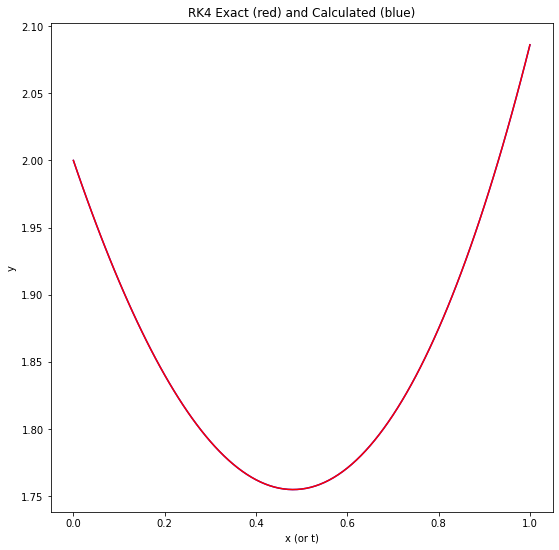

In [38]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/RK4Data1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('RK4 Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='b')
ax.plot(positionList, calculatedList, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

Since it's so hard to see anything interesting in these graphs, instead of plotting the results next to each other, let us plot the errors directly. 

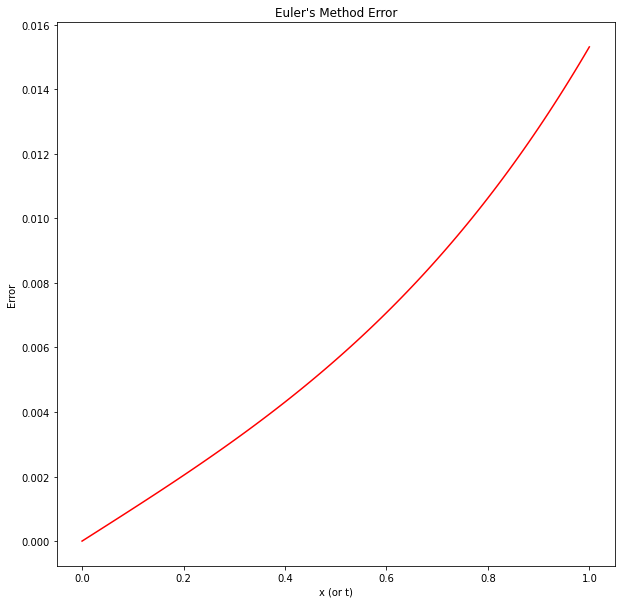

In [14]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/EulerData1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title('Euler\'s Method Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

The shape of the other methods is virtually identical in all except for amplitude. Errors grow with time, as should be expected, for every error adds to the error of the next step. Let us examine the RK4 error...

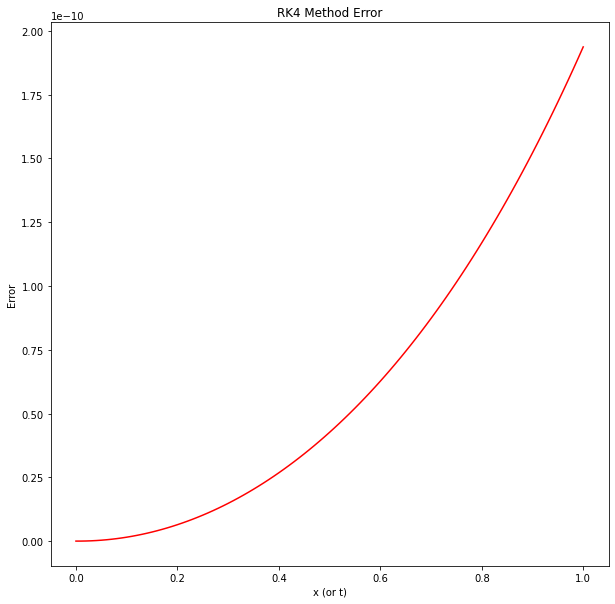

In [15]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/RK4Data1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title('RK4 Method Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

One may note the similar shape of these graphs, but that their *scale* is different. RK4 is orders of magnitude different from Euler's in terms of error, even if the error behaves the same in each of them. If we compare to the actual true calculated value, Euler's method is off by 1/100th by the time we reach x=1 and RK4 by 1/10,000,000,000th.

Now, our order checker sometimes has difficulty with higher-accuracy methods. There is a second way we can check for proper error order, though it involves eyeballing a graph rather than getting out a specific number. To do this, we need to run another test at a different step size, specifically half. 

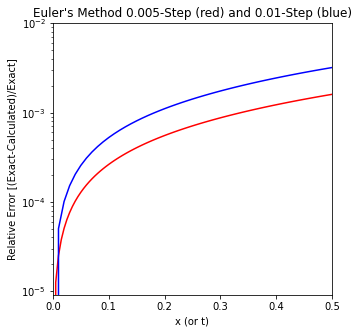

In [16]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/EulerData2.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))
        
with open(sys.path[0] + '/EulerData1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('Euler\'s Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='r')
ax.plot(positionList2, error2List, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0.0,0.5)
ax.set_yscale("log") #found in matplotlib's documentation.

fig.set_size_inches(5,5)
fig.title = 'Title'

Ignoring the "early weirdness," these two errors are clearly related.

Now, the error we are comparing here is not first-step order, it is error at any time step. This error will be EQUAL to the order of the method, not equal to it plus 1, since the error compounds in such a way that it is multiplied by the number of steps, which is effectively dividing by 1/step, lowering the order of the error to the method order. To demonstrate this, let us divide the values of the blue data by 2 (which is first order error, 2^1).

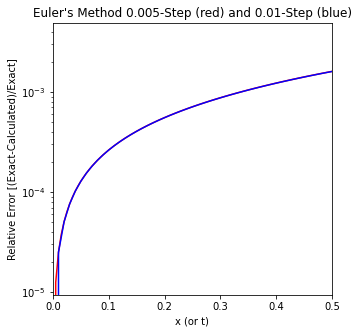

In [17]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/EulerData2.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))
        
with open(sys.path[0] + '/EulerData1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(abs(float(row[7])/(float(row[3])+0.000000000000001))/2.0)

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('Euler\'s Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='r')
ax.plot(positionList2, error2List, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0.0,0.5)
ax.set_yscale("log") #found in matplotlib's documentation.

fig.set_size_inches(5,5)
fig.title = 'Title'

And they match! Exactly as they should. We can do a similar thing with RK4, but notably the division will be ($2^4 = 16$).

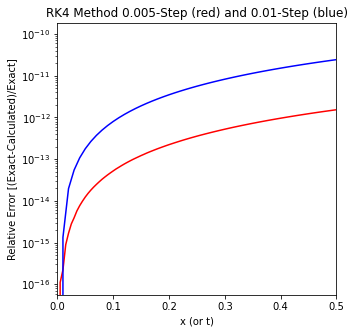

In [18]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/RK4Data2.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))
        
with open(sys.path[0] + '/RK4Data1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('RK4 Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='r')
ax.plot(positionList2, error2List, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0.0,0.5)
ax.set_yscale("log") #found in matplotlib's documentation.

fig.set_size_inches(5,5)
fig.title = 'Title'

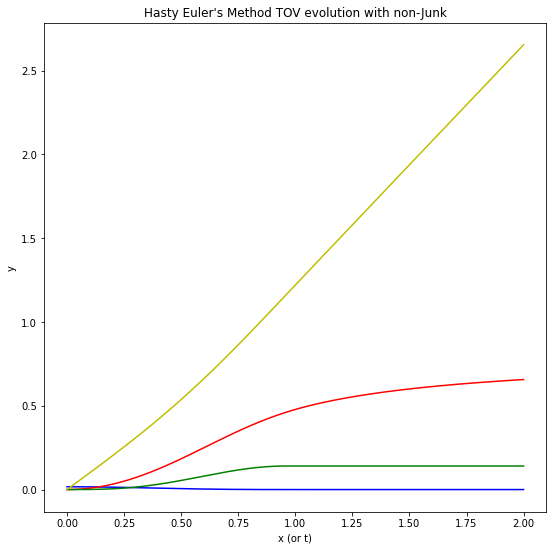

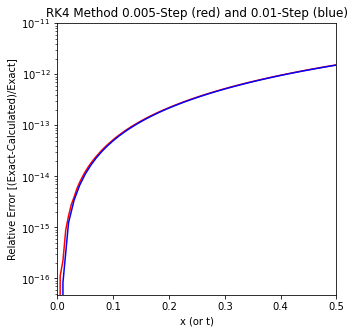

In [19]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Hasty Euler\'s Method TOV evolution with non-Junk')
ax.plot(positionList, calculatedList0, color='b') 
       
ax.plot(positionList, calculatedList1, color='r') 

ax.plot(positionList, calculatedList2, color='g') 

ax.plot(positionList, calculatedList3, color='y')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open(sys.path[0] + '/RK4Data2.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(abs(float(row[7])/(float(row[3])+0.000000000000001)))
        
with open(sys.path[0] + '/RK4Data1.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(abs(float(row[7])/(float(row[3])+0.000000000000001))/16.0)

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('RK4 Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='r')
ax.plot(positionList2, error2List, color='b') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0.0,0.5)
ax.set_yscale("log") #found in matplotlib's documentation.

fig.set_size_inches(5,5)
fig.title = 'Title'

And they match, confirming the fourth-order error for RK4. 

<a id='S4'></a>

# Step 4: Conclusion \[Back to [top](#toc)\]
$$\label{S4}$$

#### So, what have we learned today?

Now that we have arrived at the end, what now? Well, we are reasonably confident that all the methods are coded correctly and that the solver is accurate. We have also found holes where there will be some imperfections in the code, but have deduced that they are of minimal concern to the overall functionality of the method. 

Normally at this point we would go into how a user would make use of the code, but this is currently just a preliminary code that doesn't have all its features, so in the end this is more of a placeholder. More detailed instructions on use and warnings will go here eventually. 

In summary, the code works and is almost ready to move on to the next stage: multiple ODEs solved at once as a system. But before we do that, there is another mode of functionality: allowing the code to be passed NRPy's Butcher Tables in order to use *any* possible Runge-Kutta-like method. 

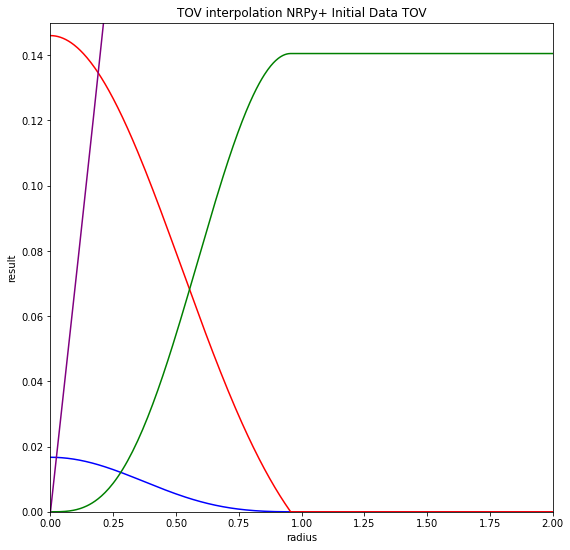

In [22]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytrope.txt') as f: 
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV interpolation NRPy+ Initial Data TOV')
ax.plot(positionList, calculatedList0, color='b') 
       
ax.plot(positionList, calculatedList1, color='r') 

ax.plot(positionList, calculatedList2, color='g') 

ax.plot(positionList, calculatedList3, color='purple')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 

plt.xlim(0.0,2)
plt.ylim(0.0,0.15)
# setting size was annoying.
fig.set_size_inches(9,9)

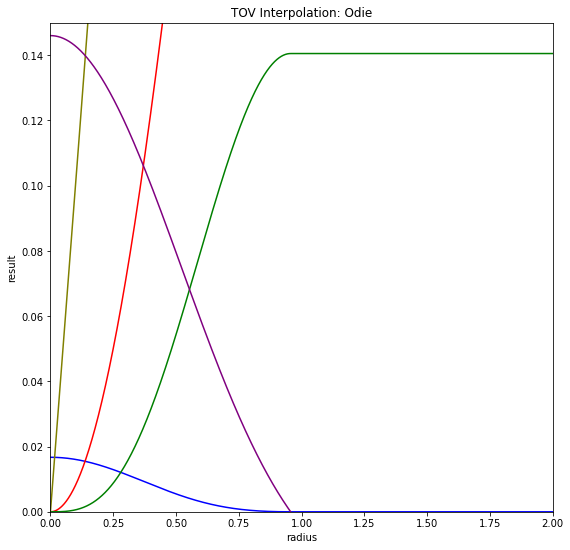

In [24]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
calculatedList4 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))
        calculatedList4.append(float(row[10]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV Interpolation: Odie')
ax.plot(positionList, calculatedList0, color='b') 
       
ax.plot(positionList, calculatedList1, color='r') 

ax.plot(positionList, calculatedList2, color='g') 

ax.plot(positionList, calculatedList3, color='olive')

ax.plot(positionList, calculatedList4, color='purple')
plt.ylim(0,0.15)
plt.xlim(0,2)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)

So here's the problem. The first step of every RK-type method is the same: Calculate K1. 

$$K_1 = f(t_0, y_{n0})$$

Now, for the TOV (and many other equations) we need to interpolate over the radius r.

$$K_1 = f(r_0, y_{n0})$$

But we need to start the evolution at r=0. This is a tremendous problem, seeing as so, so many of the equations we deal with are of the form 

$$ f(r,y) = \frac{y}{r} $$

Which is to say, y' = y/r. An example of an important funciton of this sort is the TOV pressure equation. 

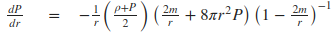

Which, while we can certanly set the pressure to have a value at r=0, the slope at r=0 approaches infinity. However, the value of the slope at r=0 is fundamental in calculating the first K constant. So how do we deal with this? 

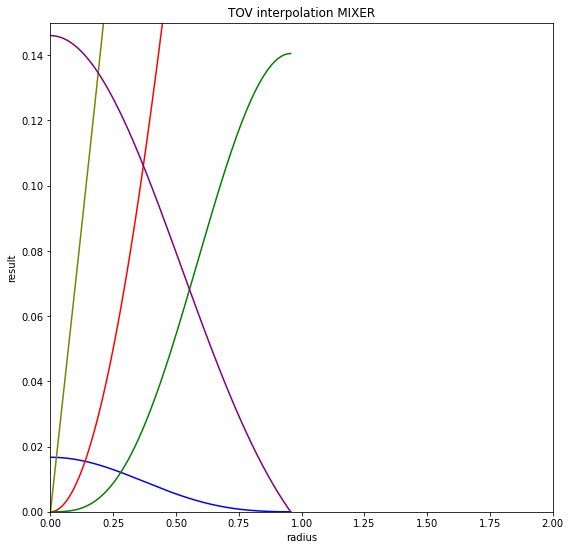

In [49]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytrope.txt') as f: 
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV interpolation MIXER')
#ax.plot(positionList, calculatedList0, color='b') 
       
#ax.plot(positionList, calculatedList1, color='r') 

#ax.plot(positionList, calculatedList2, color='g') 

#ax.plot(positionList, calculatedList3, color='purple')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 

plt.xlim(0.0,2)
plt.ylim(0.0,0.15)
# setting size was annoying.
fig.set_size_inches(9,9)

#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import numpy as np

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

R_Schw    = 9.566044579232513e-01
M         = 1.405030336771405e-01
Rbar_Schw = 1.157461364e+00#8.100085557410308e-01
C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw        
        
ax.plot(apositionList, acalculatedList0, color='b') 
       
ax.plot(apositionList, acalculatedList1, color='r') 

ax.plot(apositionList, acalculatedList2, color='g') 

ax.plot(apositionList, np.array(acalculatedList3)*C, color='olive')

ax.plot(apositionList, acalculatedList4, color='purple')
plt.ylim(0,0.15)
plt.xlim(0,2)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)



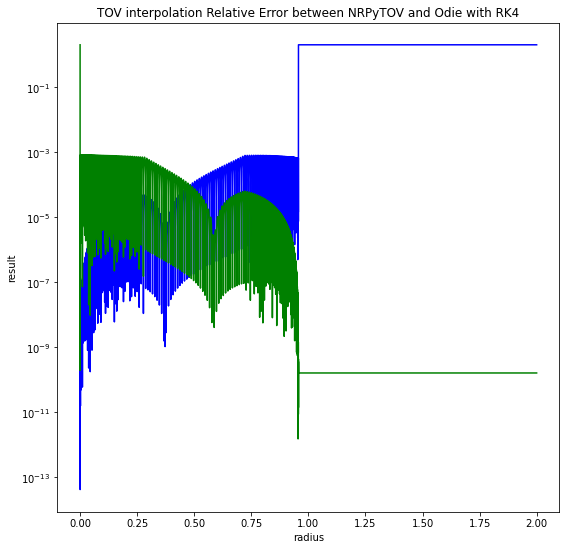

In [138]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytrope.txt') as f: 
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV interpolation Relative Error between NRPyTOV and Odie with RK4')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 

# setting size was annoying.
fig.set_size_inches(9,9)

#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []


# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[10]))

R_Schw    = 9.566044579232513e-01
M         = 1.405030336771405e-01
Rbar_Schw = 1.157461364e+00#8.100085557410308e-01

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpolatedList0 = np.interp(apositionList, positionList, np.array(calculatedList0))

ax.plot(apositionList, abs(2.0*(interpolatedList0-np.array(acalculatedList0))/(abs(interpolatedList0) + abs(np.array(acalculatedList0)))), color='b') 

interpolatedList2 = np.interp(apositionList, positionList, np.array(calculatedList2))

ax.plot(apositionList, abs(2.0*(interpolatedList2-np.array(acalculatedList2))/(abs(interpolatedList2) + abs(np.array(acalculatedList2)))), color='g') 

# ax.plot(apositionList, acalculatedList1, color='r') 

#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList0))-np.array(acalculatedList0), color='b')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList2))-np.array(acalculatedList2), color='g')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList3))-np.array(acalculatedList3)*C, color='olive')
#ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList1))-np.array(acalculatedList4), color='purple')

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList2))-np.array(acalculatedList2), color='g') 

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList3))-np.array(acalculatedList3)*C, color='olive') 

# ax.plot(apositionList, np.interp(apositionList, positionList, np.array(calculatedList1))-np.array(acalculatedList4), color='purple') 



# ax.plot(apositionList, apositionList, color='k') 

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

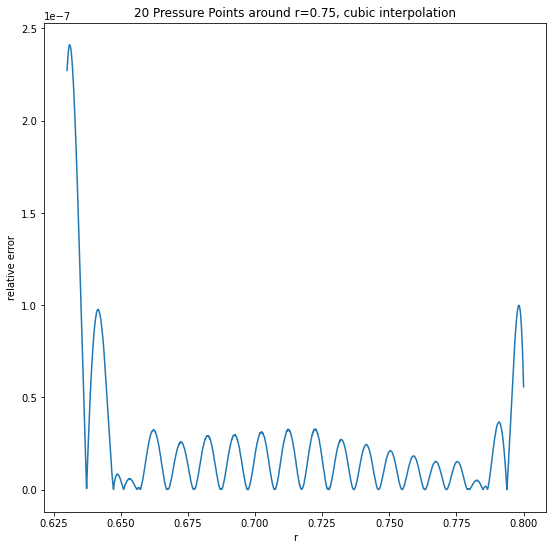

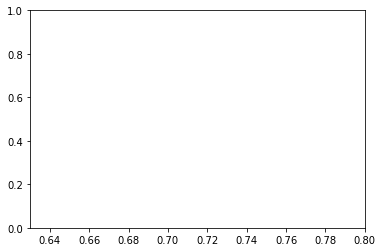

In [241]:
#Testing Box

#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import scipy.interpolate as scy
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []



# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
n = 0
with open(sys.path[0] + '/HandpickedPoints2.txt') as f: 
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        if (n % 2 == 0): 
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[4]))
            calculatedList1.append(float(row[10]))
            calculatedList2.append(float(row[13]))
            calculatedList3.append(float(row[14]))
        else:
            apositionList.append(float(row[0]))
            acalculatedList0.append(float(row[3]))
            acalculatedList1.append(float(row[4]))
            acalculatedList2.append(float(row[7]))
            acalculatedList3.append(float(row[1]))

        n = n+1

bpositionList = []
bcalculatedList0 = []
bcalculatedList1 = []
bcalculatedList2 = []
bcalculatedList3 = []
bcalculatedList4 = []

with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        bpositionList.append(float(row[1]))
        bcalculatedList0.append(float(row[3]))
        bcalculatedList1.append(float(row[5]))
        bcalculatedList2.append(float(row[7]))
        bcalculatedList3.append(float(row[9]))
        bcalculatedList4.append(float(row[10]))

fig, ax = plt.subplots()
ax.set_xlabel('r')
ax.set_ylabel('relative error')
ax.set_title('20 Pressure Points around r=0.75, cubic interpolation')

R_Schw    = 9.566044579232513e-01
M         = 1.405030336771405e-01
Rbar_Schw = 1.157461364e+00#8.100085557410308e-01

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

#ax.plot(bpositionList, interpList0, color='b')

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.array(positionList)
y = np.array(calculatedList0)
f = interpolate.interp1d(x, y, "cubic")
f2 = interpolate.interp1d(np.array(bpositionList), np.array(bcalculatedList0),"cubic")
xnew = np.arange(0.63, 0.80, 0.0001)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
ynew2 = f2(xnew)
plt.plot(xnew, abs((ynew-ynew2)/ynew), '-')
fig.set_size_inches(9,9)
plt.show()

#ax.plot(xNew, yNew, color='b')

#ax.plot(bpositionList, abs((interpList0-np.array(bcalculatedList0))/interpList0), color='b') 
#ax.plot(calculatedList0, acalculatedList0, color='b') 
       
#ax.plot(calculatedList1, acalculatedList1, color='r') 

#ax.plot(calculatedList2, acalculatedList2, color='g') 

#ax.plot(calculatedList3, acalculatedList3, color='olive')

#interpolatedList0 = np.interp(apositionList, positionList, np.array(calculatedList0))

#ax.plot(apositionList, abs(2.0*(interpolatedList0-np.array(acalculatedList0))/(abs(interpolatedList0) + abs(np.array(acalculatedList0)))), color='b') 

#interpolatedList2 = np.interp(apositionList, positionList, np.array(calculatedList2))

#ax.plot(apositionList, abs(2.0*(interpolatedList2-np.array(acalculatedList2))/(abs(interpolatedList2) + abs(np.array(acalculatedList2)))), color='g') 


# ax.plot(apositionList, apositionList, color='k') 
# plt.ylim(0,0.001)
plt.xlim(0.63,0.8)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

/tmp/ipykernel_12870/2013843999.py:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(apositionList**2/acalculatedList3**2)


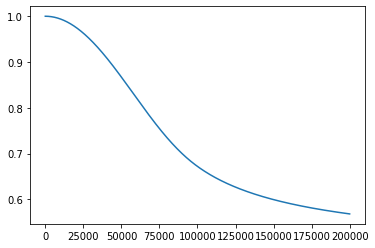

In [24]:
import numpy as np
apositionList = np.array(apositionList)
acalculatedList3 = np.array(acalculatedList3)
plt.plot(apositionList**2/acalculatedList3**2)

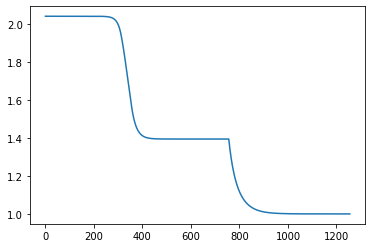

In [25]:
positionList = np.array(positionList)
calculatedList3 = np.array(calculatedList3)
plt.plot(positionList**2/calculatedList3**2)

In [26]:
acalculatedList3

array([0.00000000e+00, 1.00000000e-05, 2.00000000e-05, ...,
       2.65331545e+00, 2.65332976e+00, 2.65334407e+00])

In [27]:
calculatedList3

array([6.99810887e-06, 7.23137917e-06, 7.47242514e-06, ...,
       8.92753819e+04, 9.13548760e+04, 9.34828077e+04])

<a id='S5'></a>

# Step 5: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{S5}$$

((This is currently not functional due to file hierarchy, when in the actual nrpytutorial repo it will work)). 

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[OSESolver.pdf](ODESolver.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [29]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("ODESolverV2")

[NbConvertApp] WARNING | pattern 'ODESolverV2.ipynb' matched no files
Created ODESolverV2.tex, and compiled LaTeX file to PDF file
    ODESolverV2.pdf
